# Classical Shadow for Directly Fidelity Prediction

In [1]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit import quantum_info
from qiskit.primitives import StatevectorEstimator
import numpy as np
from qiskit import transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

In [2]:
# Prepare n-qubit GHZ state
def GHZ_state(num_qubits, qc):
    qc.h(0)
    for cnot in range(num_qubits - 1):
        qc.cx(cnot, cnot + 1)
    qc.barrier()

def bitGateMap(qc,g,qi):
    '''Map X/Y/Z string to qiskit ops'''
    if g=="X":
        qc.h(qi)
    elif g=="Y":
        qc.sdg(qi)
        qc.h(qi)
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")

# Generate an pure state operator for fidelity prediction    
def gen_op(ket):
    return np.outer(ket, np.conj(ket))

# Inverse Channel
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

In [3]:
# An Example GHZ state via Classical shadow
num_shadows = 2000 # number of classical shadows
reps = 1
N = 4 # number of qubits

In [4]:
rng = np.random.default_rng(1717)
cliffords = [quantum_info.random_clifford(N, seed=rng) for _ in range(num_shadows)]

qc1 = QuantumCircuit(N)
GHZ_state(N,qc1)
state =  Statevector(qc1) # GHZ state
op = gen_op(state) # Pure operator
results = []
for cliff in cliffords:
    qc_c  = qc1.compose(cliff.to_circuit())

    counts = quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

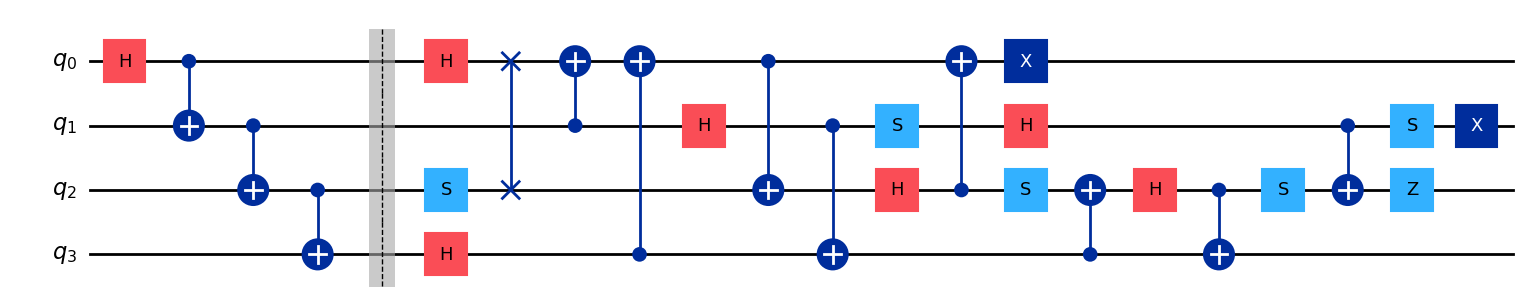

In [5]:
qc_c.draw(output='mpl')

In [6]:
# Generate Classical shadow
shadows = []
for cliff, res in zip(cliffords, results):
    mat   = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(N,np.outer(Ub,Ub.conj()))*count)

## Median-of-Means Estimation
Suppose we want to predict the expectation value of an operator $\hat{O}$.
* Divide the Classical Shadow into K parts. with $\hat{\rho}_{(k)}=\frac{1}{\lfloor N / K\rfloor} \sum_{i=(k-1)\lfloor N / K\rfloor+1}^{k\lfloor N / K\rfloor} \hat{\rho}_i$
* *Predict $\hat{o}$= \textrm{median}($\cfrac{1}{N/K}\sum\limits_{i=1}^{N/K}\text{Tr}(O\hat{\rho_{(1)}}),...,\cfrac{1}{N/K}\sum\limits_{i=N-N/K+1}^{N}\text{Tr}(O\hat{\rho_{(i)}})$)


In [7]:
def median_of_means_est(shadows, num_blocks, op):
    shadow_block = []
    fid = []
    block_size = len(shadows) // num_blocks

    for k in range(num_blocks):

        idx = k * block_size
        if k == num_blocks - 1:
            end_idx = len(shadows)
        else:
            end_idx = (k + 1) * block_size

        block_shadows = shadows[idx: end_idx]

        rho_k = np.sum(block_shadows, axis=0) / len(block_shadows)
        shadow_block.append(rho_k)

        fid_k = np.trace(op @ rho_k)
        fid_k = np.sqrt(fid_k * fid_k.conj()) # Real Number
        fid.append(fid_k)
    return shadow_block, fid


In [8]:
# One Test
shadow_block, fid_block = median_of_means_est(shadows, 10, op)
print(fid_block)


print(np.median(fid_block))

[np.complex128(1.0346874999999993+0j), np.complex128(0.981562499999999+0j), np.complex128(0.9018749999999991+0j), np.complex128(1.034687499999999+0j), np.complex128(1.0984374999999988+0j), np.complex128(0.9178124999999993+0j), np.complex128(1.0506249999999993+0j), np.complex128(0.9284374999999991+0j), np.complex128(0.8540624999999992+0j), np.complex128(1.055937499999999+0j)]
(1.008124999999999+0j)


In [9]:
# Run Independent Experiments for Data Analysis
num_exp = 3
fid_mid = []

for _ in range(num_exp):
    results = []
    qc_test = QuantumCircuit(N)
    cliffords = [quantum_info.random_clifford(N) for _ in range(num_shadows)]
    state = GHZ_state(N, qc_test)
    for cliff in cliffords:
         qc_c  = qc_test.compose(cliff.to_circuit())

         counts = quantum_info.Statevector(qc_c).sample_counts(reps)
         results.append(counts)
    shadows = []
    for cliff, res in zip(cliffords, results):
        mat   = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadows.append(Minv(N,np.outer(Ub,Ub.conj()))*count)

    shadow_block, fid_block = median_of_means_est(shadows, 10, op)
    
    fid_mid.append(np.median(fid_block))

c:\Users\86188\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\86188\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\86188\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:3413: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


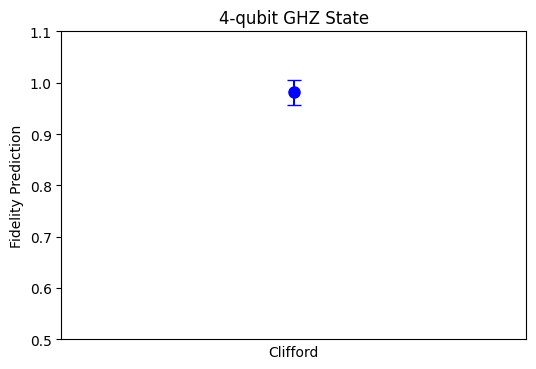

In [10]:
# Visualization
plt.figure(figsize=(6, 4))
plt.errorbar(
    x = [1],
    y = [np.mean(fid_mid)],
    yerr = [np.std(fid_mid)],
    fmt = 'o',
    capsize = 5,
    label = 'Fidelity Prediction',
    color = 'b',
    markersize = 8,
    linestyle = 'none'
)

plt.title(f'{N}-qubit GHZ State')
plt.ylabel('Fidelity Prediction')
plt.xlabel('Clifford')
plt.ylim(0.5, 1.1)
plt.xticks([])

plt.show()